In [33]:
# Handling missing data

# modules we'll use
import pandas as pd
import numpy as np
import datetime

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# get continent name from country
import pycountry_convert as pc

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# read in all our data
ks_projects_orig  = pd.read_csv("../src/ks-projects-201801.csv")

# set seed for reproducibility
np.random.seed(0) 

# look at a few rows of the ks_projects file. I can see a handful of missing data already!
ks_projects_orig.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
338862,796196901,10G Christmas Tree,Art,Art,USD,2010-12-26,10526.0,2010-12-08 08:44:04,0.0,failed,0,US,0.0,0.0,10526.0
277871,483825010,Gliff,Gaming Hardware,Games,USD,2016-03-28,10000.0,2016-01-28 04:56:18,51.0,failed,5,US,51.0,51.0,10000.0
47000,123916947,STUFFED Food Truck,Food Trucks,Food,USD,2015-01-06,60000.0,2014-11-07 02:24:36,25.0,failed,1,US,25.0,25.0,60000.0
111338,1565733636,NeoExodus Adventure: Origin of Man for Pathfin...,Tabletop Games,Games,USD,2012-05-01,500.0,2012-03-15 01:16:10,585.0,successful,17,US,585.0,585.0,500.0
53743,1273544891,NAPOLEON IN NEW YORK! an original TV Series,Comedy,Film & Video,USD,2016-07-26,25000.0,2016-05-27 00:07:25,25.0,failed,1,US,25.0,25.0,25000.0


In [34]:
# get the number of missing data points per column
missing_values_count = ks_projects_orig.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count[0:15]

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [35]:
# how many total missing values do we have?
total_cells = np.product(ks_projects_orig.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

0.06692001552840139

In [36]:
# remove all columns with at least one missing value
ks_projects_cleaned = ks_projects_orig.dropna(axis=1)
ks_projects_cleaned.head()

,ID,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,1533.95
1,1000003930,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,2421.0,30000.00
2,1000004038,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,45000.00
3,1000007540,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,5000.00
4,1000011046,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,19500.00


In [37]:
# just how much data did we lose?
print("Columns in original dataset: %d" % ks_projects_orig.shape[1])
print("Columns with na's dropped: %d" % ks_projects_cleaned.shape[1])
print("Rows in original dataset: %d" % ks_projects_orig.shape[0])
print("Rows with na's dropped: %d" % ks_projects_cleaned.shape[0])

Columns in original dataset: 15
Columns with na's dropped: 13
Rows in original dataset: 378661
Rows with na's dropped: 378661


In [38]:
# remove all rows with country value 'N,0"'
ks_projects_cleaned = ks_projects_cleaned[ks_projects_cleaned.country != 'N,0"']

In [39]:
# just how much data did we lose?
print("Rows in original dataset: %d" % ks_projects_orig.shape[0])
print("Rows with na's dropped: %d" % ks_projects_cleaned.shape[0])

Rows in original dataset: 378661
Rows with na's dropped: 374864


In [40]:
# Parsing Dates

## print the first few rows of the date column
print(ks_projects_cleaned['deadline'].head())

# create a new column, deadline_parsed, with the parsed dates
ks_projects_cleaned['deadline_parsed'] = pd.to_datetime(ks_projects_cleaned['deadline'], format = "%Y-%m-%d")

# print the first few rows
ks_projects_cleaned['deadline_parsed'].head()

0    2015-10-09
1    2017-11-01
2    2013-02-26
3    2012-04-16
4    2015-08-29
Name: deadline, dtype: object


0   2015-10-09
1   2017-11-01
2   2013-02-26
3   2012-04-16
4   2015-08-29
Name: deadline_parsed, dtype: datetime64[ns]

In [41]:
# create a new column, launched_parsed, with the parsed dates
ks_projects_cleaned['launched_parsed'] = pd.to_datetime(ks_projects_cleaned['launched'], format = "%Y-%m-%d")

# print the first few rows
ks_projects_cleaned['launched_parsed'].head()

0   2015-08-11 12:12:28
1   2017-09-02 04:43:57
2   2013-01-12 00:20:50
3   2012-03-17 03:24:11
4   2015-07-04 08:35:03
Name: launched_parsed, dtype: datetime64[ns]

In [42]:
# create a new column diff, as a difference between deadline and launched
ks_projects_cleaned['duration'] = ks_projects_cleaned['deadline_parsed'] - ks_projects_cleaned['launched_parsed'] 

# print the first few rows
ks_projects_cleaned['duration'].head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
Name: duration, dtype: timedelta64[ns]

In [43]:
# Parsing country codes

# add column with countries continents
ks_projects_cleaned['continent']  = ks_projects_cleaned.apply(lambda row: pc.country_alpha2_to_continent_code(row['country']), axis= 1)

# print the first few rows
ks_projects_cleaned['continent'].head()

0    EU
1    NA
2    NA
3    NA
4    NA
Name: continent, dtype: object

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\mlxtend\preprocessing\scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


Text(0.5, 1.0, 'Scaled data')

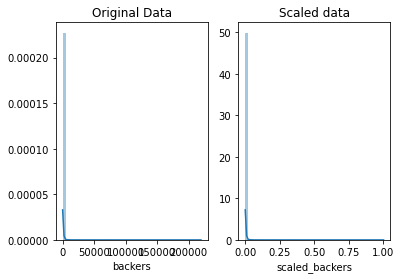

In [44]:
# Scale and Normalize Data

# select the backers column
backers = ks_projects_cleaned.backers

# scale the backers from 0 to 1
ks_projects_cleaned['scaled_backers'] = minmax_scaling(backers, columns = [0])

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(backers, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(ks_projects_cleaned['scaled_backers'], ax=ax[1])
ax[1].set_title("Scaled data")

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\mlxtend\preprocessing\scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


Text(0.5, 1.0, 'Scaled data')

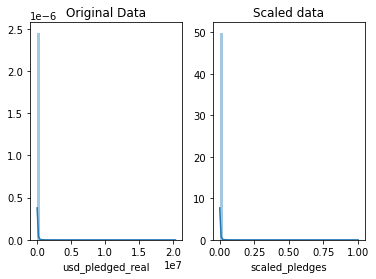

In [45]:
# select the usd_pledged_real column
usd_pledged = ks_projects_cleaned.usd_pledged_real

# scale the pledges from 0 to 1
ks_projects_cleaned['scaled_pledges'] = minmax_scaling(usd_pledged, columns = [0])

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(usd_pledged, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(ks_projects_cleaned['scaled_pledges'], ax=ax[1])
ax[1].set_title("Scaled data")

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\mlxtend\preprocessing\scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


Text(0.5, 1.0, 'Scaled data')

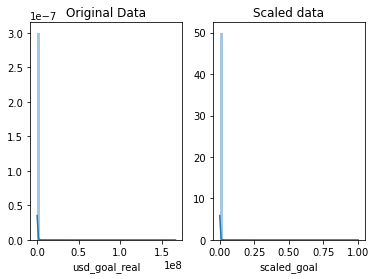

In [46]:
# select the usd_goal_real column
usd_goal = ks_projects_cleaned.usd_goal_real

# scale the goals from 0 to 1
ks_projects_cleaned['scaled_goal'] = minmax_scaling(usd_goal, columns = [0])

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(usd_goal, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(ks_projects_cleaned['scaled_goal'] , ax=ax[1])
ax[1].set_title("Scaled data")

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\mlxtend\preprocessing\scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


Text(0.5, 1.0, 'Scaled data')

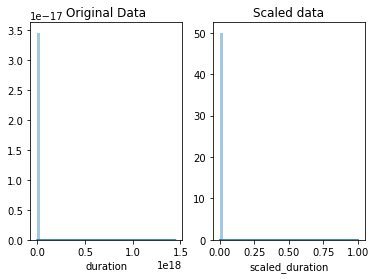

In [47]:
# select the duration column
duration = ks_projects_cleaned.duration

# scale the durations from 0 to 1
ks_projects_cleaned['scaled_duration'] = minmax_scaling(duration / np.timedelta64(1, 's'), columns = [0])

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(duration, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(ks_projects_cleaned['scaled_duration'], ax=ax[1])
ax[1].set_title("Scaled data")

Text(0.5, 1.0, 'Normalized data')

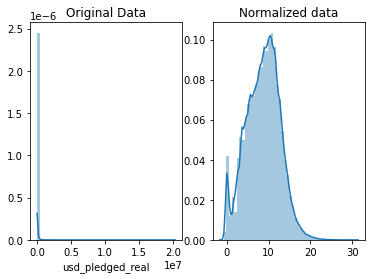

In [48]:
# get the index of all positive pledges (Box-Cox only takes positive values)
index_of_positive_pledges = ks_projects_cleaned.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = ks_projects_cleaned.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = stats.boxcox(positive_pledges)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(positive_pledges, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_pledges, ax=ax[1])
ax[1].set_title("Normalized data")
